In [2]:
from enum import Enum

class Operator(Enum):
    ADD = '+'
    MUL = '*'
    POW = '^'
    NEG = '-'
    LOG = 'ln'
    REDUCE = "RED"
    VIEW = "VIEW"
    MATMUL = '@'
    # RESHAPE ="RSHP"

    def __str__(self):
        return self.value

In [3]:
from graphviz import Digraph
from IPython.display import display

def visualize(tensor, graph='compute graph'):
    dot = Digraph(comment=graph)
    added_edges = set()

    def add_node(x):
        fillcolor = 'white' if x.requires_grad else 'lightcoral'
        if graph == 'compute graph':
            dot.node(str(id(x)), f"{x.shape}", style='filled', fillcolor=fillcolor)
        else:
            dot.node(str(id(x)), f"{x.shape}", style='filled', fillcolor=fillcolor)
    # add_node = lambda x: 
    add_op_node = lambda x: dot.node(str(id(x)), str(x.type))

    def add_edge(start,end):
        x = str(id(start))
        y = str(id(end))
        edge = (x,y)
        if edge not in added_edges:
            dot.edges([edge])
            added_edges.add(edge)


    def make_graph(t: Tensor):
        add_node(t)
        if t.op:
            add_op_node(t.op)
            if graph == 'compute graph':
                add_edge(t.op, t)
            else: 
                add_edge(t, t.op)

            if t.op.left:
                make_graph(t.op.left)
                if graph == 'compute graph':
                    add_edge(t.op.left, t.op)
                else: 
                    add_edge(t.op, t.op.left)

            if t.op.right:
                make_graph(t.op.right)
                if graph =='compute graph':
                    add_edge(t.op.right, t.op)
                else:
                    add_edge(t.op, t.op.right)
    make_graph(tensor)
    display(dot)

In [4]:
from dataclasses import dataclass
class Op:
    def __init__(self, type: str, left, right=None):
        self.type = type
        self.left = left
        self.right = right

In [ ]:
import numpy as np

class Tensor:
    def __init__(self, data, op: Op |None = None, requires_grad: bool = True, grad= None, is_view=False):
        if isinstance(data, np.ndarray):
            self.data = data if data.dtype == np.float32 else data.astype(np.float32)
        else:
            self.data = np.array(data, dtype=np.float32)
        self.op = op
        self.requires_grad = requires_grad
        self._grad = grad
        self.is_view = is_view

    @staticmethod
    def randn(*shape, requires_grad: bool = True):
        data = np.random.randn(*shape).astype(dtype=np.float32)
        return Tensor(data, requires_grad=requires_grad)

    @property
    def grad(self):
        if self._grad is None and self.requires_grad:
            self._grad = np.zeros_like(self.data)
        return self._grad

    @grad.setter
    def grad(self, value):
        if self._grad is None:# no need for this
            return 
        self._grad = value
    
    @property
    def shape(self):
        return self.data.shape

    @staticmethod
    def ensure_tensor(value, requires_grad=False):
        return value if isinstance(value, Tensor) else Tensor(value, requires_grad=requires_grad)

    def validate_arg(fn):
        def wrapper(self, other):
            other = Tensor.ensure_tensor(other, requires_grad=False)
            return fn(self, other)
        return wrapper

    @validate_arg
    def __add__(self, other):
        n = self.data + other.data
        op = Op(Operator.ADD, self, other)
        return Tensor(n, op)

    def __radd__(self, other):
        return self + other

    @validate_arg
    def __mul__(self, other):
        n = self.data * other.data
        op = Op(Operator.MUL, self, other)
        return Tensor(n, op)
    
    def __rmul__(self, other):
        return self * other
    
    @validate_arg
    def __pow__(self, power):
        n = np.power(self.data, power.data)
        op = Op(Operator.POW, self, power)
        return Tensor(n, op)
    
    @validate_arg
    def __rpow__(self, base):
        return base ** self
    
    @validate_arg
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return -self + other
    
    @validate_arg
    def __truediv__(self, other):
        return self * other ** -1 
    
    def __rtruediv__(self, other):
        return other * self ** -1

    def __neg__(self):
        data = -self.data
        op = Op(Operator.NEG, self)
        return Tensor(data, op)
    
    def log(self):
        data = np.log(self.data)
        op = Op(Operator.LOG, self)
        return Tensor(data, op)

    @staticmethod
    def sigmoid(x):
        return 1/(1+Tensor.exp(-x))

    @staticmethod
    def exp(x):
        e = Tensor(np.exp(1.0), requires_grad=False)
        return e ** x
    
    def sum(self):
        data = self.data.sum()
        op = Op(Operator.REDUCE, self)
        return Tensor(data, op)

    def dot(self, other):
        assert self.data.shape == other.data.shape and self.data.ndim == 1, f"Dot product requires 1D tensors of the same shape, got {self.data.shape} and {other.data.shape}"
        mul:Tensor = self * other
        # print(type(mul))
        return mul.sum()


    def matmul(self, other):
        assert self.data.shape[-1] == other.data.shape[0], f"Shapes {self.data.shape} and {other.data.shape} not aligned for matmul"

        value = self.data @ other.data
        op = Op(Operator.MATMUL, self, other)
        return Tensor(value, op)

    def backward(self):
        self.grad += 1.0
        self._backward()

    def update_grad(self, value):
        if self.grad is None:
            return
        if self.grad.shape != value.shape:
            value = value.sum()
        self.grad += value

    def _backward(self):
        op = self.op
        if not op:
            return

        match op.type:
            case Operator.ADD | Operator.REDUCE | Operator.VIEW:
                left_grad = right_grad = self.grad

            case Operator.MUL:
                left_grad = self.grad * op.right.data 
                right_grad = self.grad * op.left.data

            case Operator.POW:
                n = op.right.data
                left_grad = self.grad * n * op.left.data ** (n-1)

                base = op.left.data
                right_grad = self.grad * self.data * np.log(base)

            case Operator.NEG:
                assert op.right is None, "Unary Operation can't have two operands"
                left_grad = -self.grad
            case Operator.LOG:
                assert op.right is None, "Unary Operation can't have two operands"
                left_grad = self.grad * (op.left.data ** -1)
            
            case Operator.MATMUL:
                left_grad = self.grad @ op.right.data.T
                right_grad = op.left.data.T @ self.grad

        op.left.update_grad(left_grad) 

        # if op.left:
        op.left._backward() 
        if op.right:
            op.right.update_grad(right_grad) 
            op.right._backward()
    
    def item(self):
        return self.data.item()
    def __repr__(self):
        return f"Tensor(data=\n{self.data},\ngrad=\n{self.grad}, requires_grad={self.requires_grad}, op={self.op})"

    def __getitem__(self, key):
        data_view = self.data[key]
        grad_view = self.grad[key]
        op = Op(Operator.VIEW, self)
        return Tensor(data_view, op, self.requires_grad, grad_view, is_view=True)
    def __len__(self):
        return self.data.size

    # def reshape(self, *arg):   
    #     op = Op(Operator.RESHAPE, self) 
    #     return Tensor(self.data.reshape(*arg), self.requires_grad)

@dataclass
class Optimizer:
    params: list[Tensor]
    lr: float= 0.01

    def step(self):
        for param in self.params:
            if param.requires_grad:
                param.data = param.data - self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.fill(0)

In [7]:
class Module:
    def params(self):
        return self._collect_params(self.__dict__)

    def _collect_params(self, obj):
        params = []

        if isinstance(obj, Tensor):
            params.append(obj)

        elif isinstance(obj, Module):
            params.extend(obj.params())

        elif isinstance(obj, dict):
            for v in obj.values():
                params.extend(self._collect_params(v))

        elif isinstance(obj, (list, tuple)):
            for item in obj:
                params.extend(self._collect_params(item))

        return params
    def __call__(self, *args, **kwds):
        return self.forward(*args, **kwds)

In [8]:
class Linear(Module):
    def __init__(self, in_features:int , out_features: int, bias=True):
        self.input = in_features
        self.output = out_features
        self.bias_flag = bias

        self.weights = Tensor.randn(in_features, out_features)
        if bias:
            self.bias = Tensor.randn(out_features)
        else: 
            self.bias = [0]*len(self.output) # on the assumption that raw int value converted to Tensor are always with requires grad= False

    def forward(self, x):
        # assert len(x[0]) == self.input, f"Got {len(x)} features, expected {self.input}"

        return x.matmul(self.weights) + self.bias


In [9]:
class XOR(Module):
    def __init__(self):
        self.hidden_layer = Linear(2,2)
        self.output_layer = Linear(2,1)
        self.activation = Tensor.sigmoid

    def forward(self, x):
        # x [B, F]
        x = self.hidden_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x
        # return self.activation(x) #if prob = 0 then log(0) will go mad; handle this in loss function

In [10]:
class BCELogitsLoss:
    def __init__(self):
        self.sigmoid = Tensor.sigmoid
        self.threshold = 1e-6
    def __call__(self, logits, labels):
        eps = self.threshold
        prob = self.sigmoid(logits)
        p= prob; y = labels
        loss = - (y * (eps + p).log() + (1-y) * (1-p + eps).log())
        return loss.sum()/len(loss)

In [112]:
# # Create input x of shape (4, 2) and target y_t of shape (4,)
# x = Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])
# y_t = np.array([0, 1, 1, 0]).reshape(-1,1)
# y_t = Tensor(y_t)

# hl = Linear(2, 3)
# hl_out = hl(x)

# # Second linear layer: 3 -> 1
# hl2 = Linear(3, 1)
# y_p = hl2(hl_out)

# # Compute loss: (y_t - y_p).sum()
# y_p = Tensor.sigmoid(y_p)
# loss = BCELogitsLoss()
# L = loss(y_p, y_t)
# L.backward()

In [11]:
def train(model, x, y, optimizer:Optimizer, loss, epoch):
    loss_history = []
    for i in range(epoch):
        optimizer.zero_grad()
        y_pred = model(x)
        output: Tensor= loss(y_pred, y)
        output.backward()
        optimizer.step()

        loss_history.append(output.item())

        if i % 100000 == 0:
            print(f"Epoch {i}: Loss: {output.item()}")
    plot(loss_history, epoch) 
    return model

def plot(loss_history, epoch):
    import matplotlib.pyplot as plt
    plt.plot(range(epoch), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.show()

In [12]:
x = Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])
y_t = np.array([0, 1, 1, 0]).reshape(-1,1)
y_t = Tensor(y_t)

In [15]:
model = XOR()
y_pred = model(x)
optimizer = Optimizer(model.params())
loss = BCELogitsLoss()
epoch = 500

In [16]:
model.params()

[Tensor(data=
 [[-0.97792774 -1.4707977 ]
  [ 2.56972    -0.49314135]],
 grad=
 [[0. 0.]
  [0. 0.]], requires_grad=True, op=None),
 Tensor(data=
 [ 0.38693365 -0.39635873],
 grad=
 [0. 0.], requires_grad=True, op=None),
 Tensor(data=
 [[0.18713999]
  [0.02080624]],
 grad=
 [[0.]
  [0.]], requires_grad=True, op=None),
 Tensor(data=
 [0.32684112],
 grad=
 [0.], requires_grad=True, op=None)]

In [17]:
ll = loss(y_pred, y_t)

In [18]:
ll

Tensor(data=
0.7238661050796509,
grad=
0.0, requires_grad=True, op=<__main__.Op object at 0x00000251761327D0>)

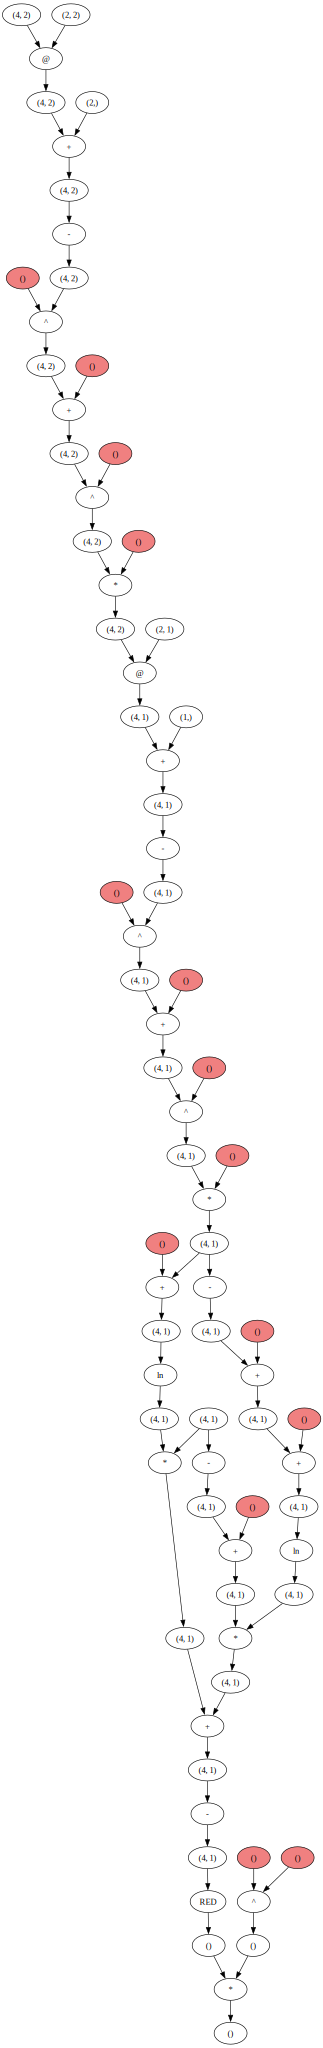

In [19]:
visualize(ll)

Epoch 0: Loss: 0.7305133938789368
Epoch 100000: Loss: 0.005609850399196148
Epoch 200000: Loss: 0.0026328349485993385
Epoch 300000: Loss: 0.0017393191810697317
Epoch 400000: Loss: 0.0013090046122670174


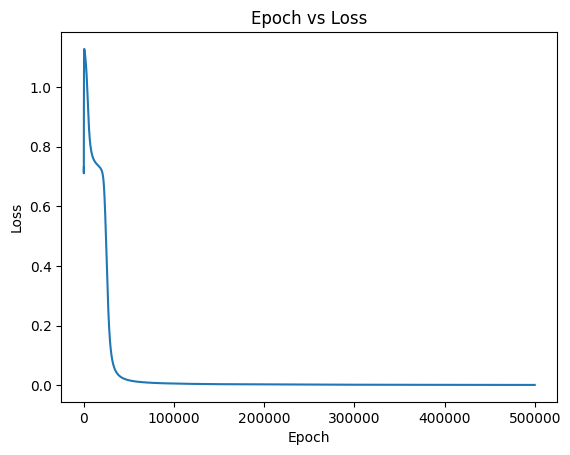

[Tensor(data=
 [[12.020374  5.444043]
  [12.02024   5.444027]],
 grad=
 [[-1.6353476e-04 -7.1526068e-05]
  [-1.6355868e-04 -7.1525646e-05]], requires_grad=True, op=None),
 Tensor(data=
 [-7.686195 -8.528824],
 grad=
 [0.00013075 0.00013075], requires_grad=True, op=None),
 Tensor(data=
 [[ 15.688915]
  [-17.102087]],
 grad=
 [[-0.00037318]
  [ 0.00040575]], requires_grad=True, op=None),
 Tensor(data=
 [-6.305077],
 grad=
 [0.00018179], requires_grad=True, op=None)]

In [160]:
model = train(model,x,y_t, optimizer, loss, epoch)
model.params()

In [161]:
y_pred = model(x)

In [162]:
sigmoid = Tensor.sigmoid
preds = [round(sigmoid(val).item()) for val in y_pred.data.flatten()]
print("Predictions:", preds)
print("Ground Truth:", y_t.data.flatten())

Predictions: [0, 1, 1, 0]
Ground Truth: [0. 1. 1. 0.]


In [ ]:
model.params()

[Tensor(data=8.638881131156573, op=None, grad=-4.3143358259775575e-05, requires_grad=True),
 Tensor(data=8.59815679574171, op=None, grad=-4.3122998766313596e-05, requires_grad=True),
 Tensor(data=6.9161657923502275, op=None, grad=-4.4476558458219365e-05, requires_grad=True),
 Tensor(data=6.961462092724807, op=None, grad=-4.459864836131179e-05, requires_grad=True),
 Tensor(data=-3.630111945647424, op=None, grad=2.3793862211873717e-05, requires_grad=True),
 Tensor(data=-10.857604200564229, op=None, grad=6.68076143842459e-05, requires_grad=True),
 Tensor(data=17.11570582353405, op=None, grad=-0.00019151165319909204, requires_grad=True),
 Tensor(data=-17.677614021074874, op=None, grad=0.00019157494178955722, requires_grad=True),
 Tensor(data=-7.349759808153165, op=None, grad=9.44045506134994e-05, requires_grad=True)]